## Linear regression on a simulated concert dataset to predict concert ticket prices 

### Import necessary libraries and establish DB connection

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
db_path = 'concerts.db'
conn = sqlite3.connect(db_path)

### Query data from DB with SQL

1) Create a dictionary with appropriate column names and data queried from corresponding tables of the database

2) Initialise a pandas dataframe which we later populate with data from the dictionary

In [3]:
db_table_names = ('artist', 'customer', 'genre', 'performance', 'ticket', 'ticketpricing')
table_df_dict = dict()

for table_name in db_table_names:
    table_df_dict[table_name] = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)

In [4]:
df = pd.DataFrame()

### Populate the DataFrame with data from the dictionary

1) *populate_with_data()* - implementation involves merging data from different tables of the database (smaller DFs - values of the dictionary) based on the id of other columns
2) split the df into X for features and y for label

In [5]:
def populate_with_data(df):
    df['Ticket Price'] = table_df_dict['ticket']['ticketPrice']
    df['Ticket Category'] = table_df_dict['ticket']['type']

    merged_df = pd.merge(table_df_dict['artist'], table_df_dict['genre'], on='idGenre', how='left')
    merged_df = pd.merge(table_df_dict['performance'], merged_df, on='idArtist', how='left')
    merged_df = pd.merge(table_df_dict['ticket'], merged_df, on='idPerformance', how='left')

    df['Artist'] = merged_df['name_x']
    df['Genre'] = merged_df['genreName']
    df['Performance Name'] = merged_df['name_y']
    df['Performance Date'] = merged_df['date']

    # df['Official Ticket Price'] = table_df_dict['ticket'].merge(
    #     table_df_dict['ticketpricing'][['idPerformance', 'Type', 'price']],
    #     left_on=['idPerformance', 'type'],
    #     right_on=['idPerformance', 'Type'],
    #     how='left'
    # )['price']

In [6]:
populate_with_data(df)
df.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Performance Date
0,2000,A,ABX,Pop,ABBA,2025-06-18 20:30:00
1,900,C,Adelaire,Pop,Adele,2025-06-19 20:30:00
2,200,D,BamaBeats,Country,Alabama,2025-06-20 20:30:00
3,1000,B,ChillSync,Rock,Coldplay,2025-06-21 20:30:00
4,900,A,Distorto,Metal,Disturbed,2025-06-25 21:30:00


In [7]:
X = df.drop('Ticket Price', axis=1)
y = df['Ticket Price']

### Visualise the data

We can use matplotlib to visualise the relationship of each of the feature columns in X to the label column y

In [95]:
def visualise_data(X, y, y_pred=None):
    for column in X:
        plt.figure(figsize=(12, 3))
        
        if column in ('Artist', 'Performance Name', 'Performance Date'):
            if column == 'Performance Date':
                short_labels = X[column].str[6:7] + X[column].str[8:10]
                short_labels = short_labels.astype(int).sort_values()
            else:
                short_labels = X[column].str[:2]
                short_labels = short_labels.sort_values()
            
            x_positions = range(len(X[column]))
            
            plt.scatter(x_positions, y, color='red')
            if y_pred is not None:
                plt.scatter(x_positions, y_pred, color='blue', marker='X')
            plt.xticks(ticks=x_positions, labels=short_labels)
        else:
            plt.scatter(X[column], y, color='red')
            if y_pred is not None:
                plt.scatter(X[column], y_pred, color='blue', marker='X')
        
        plt.title(f'Price in relation to {column.lower()}')
        plt.xlabel(f'{column}')
        plt.ylabel('Ticket Price')
        
        plt.show()

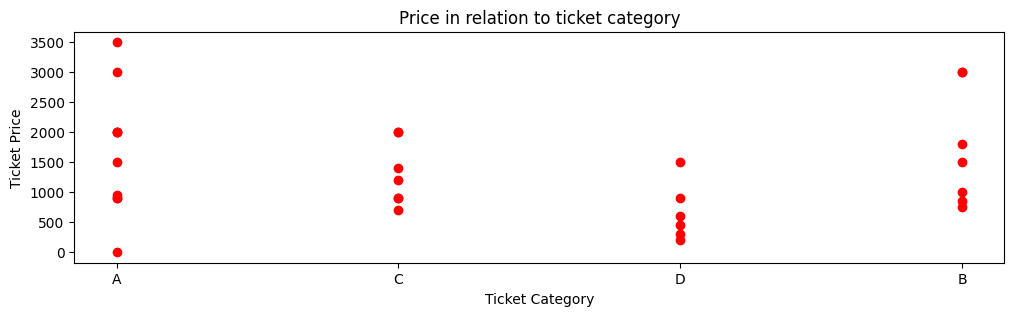

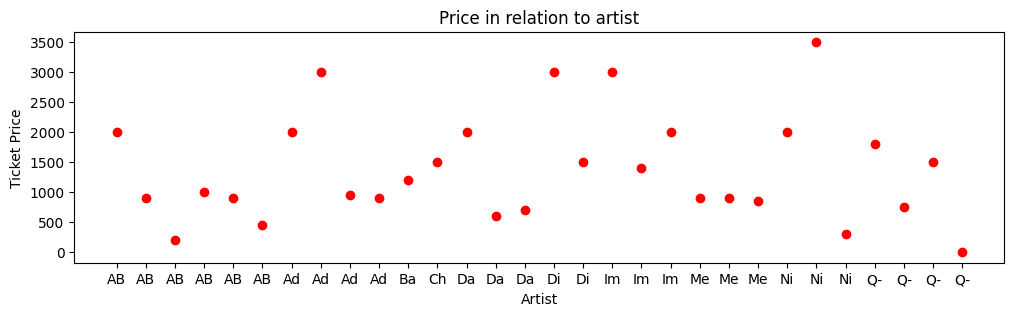

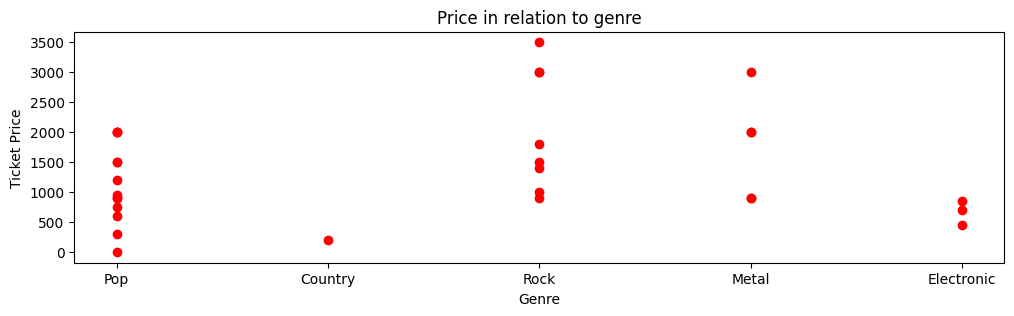

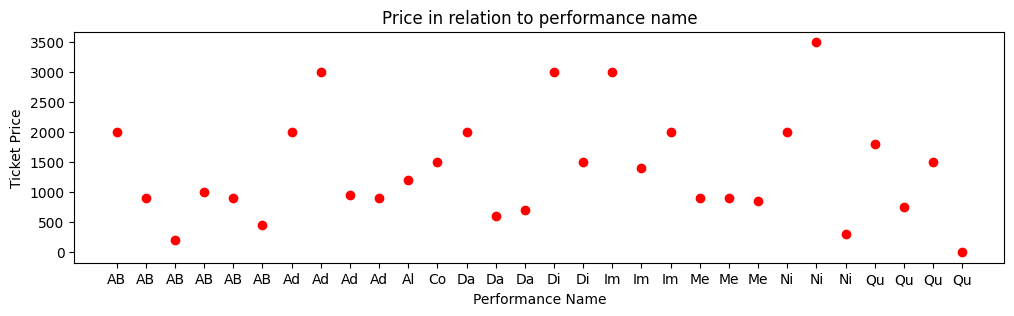

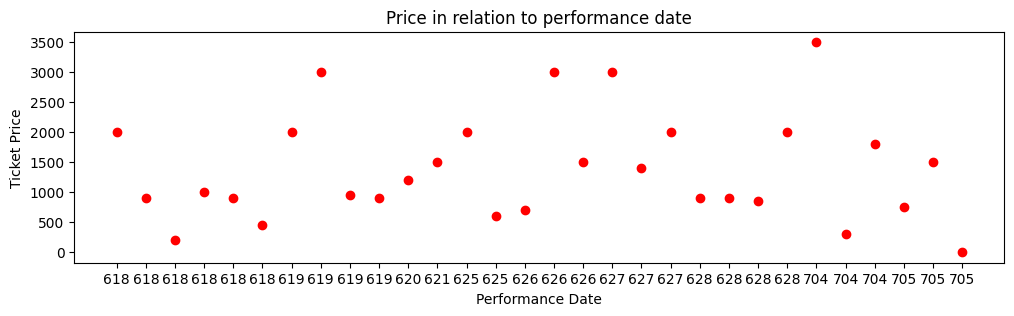

In [96]:
visualise_data(X, y)

### Encode the Performance Date column

Performance Date is represented with the date and time of the performance and looks like $i^{(1)}_{perform. date}$ = 2025-06-18 20:30:00

The date is broken up into 4 parts: (year ignored as examples only contain recent data)
- month
- day
- hour
- minute

Due to the cyclical nature of dates and times, for each of the features two new features are engineered with sin(x) and cos(x) to represent them as a point on a circle. This way, hour 23 is as close to 0 as 0 is to 1


In [8]:
def encode_date(df):
    encd_df = df.copy()
    encd_df['Month'] = df['Performance Date'].str[5:7].astype(int)
    encd_df['Day'] = df['Performance Date'].str[8:10].astype(int)
    encd_df['Hour'] = df['Performance Date'].str[11:13].astype(int)
    encd_df['Minute'] = df['Performance Date'].str[14:16].astype(int)

    date_map = {'Month': 12, 'Day': 30, 'Hour': 24, 'Minute': 60}

    for column, count in date_map.items():
        if column == 'Month' or column == 'Day':
            adjust = 1
        else:
            adjust = 0
        encd_df[f'{column} Sin'] = np.sin((encd_df[column]-adjust) * (2.*np.pi/count))
        encd_df[f'{column} Cos'] = np.cos((encd_df[column]-adjust) * (2.*np.pi/count))

    drop_cols = ['Performance Date', 'Month', 'Day', 'Hour', 'Minute']
    encd_df = encd_df.drop(drop_cols, axis=1)
    return encd_df

### One-hot-encoding for categorical data

- Categorical data is encoded into separate columns with 1s or 0s for each of the unique values it can take - this is known as one-hot-encoding

- In this instance we use sklearn's OneHotEncoder class

In [9]:
# one-hot encoding for ticket category, artist, genre, performance name columns

def one_hot_encode_df(df, cat_cols=['Ticket Category', 
                                'Artist', 'Genre', 
                                'Performance Name']):
    
    one_hot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe_array = one_hot_enc.fit_transform(df[cat_cols])

    ohe_df = pd.DataFrame(
        ohe_array,
        columns=one_hot_enc.get_feature_names_out(cat_cols),
        index=df.index
    )

    encd_df = df.drop(cat_cols, axis=1)
    encd_df = pd.concat([encd_df, ohe_df], axis=1)
    return encd_df

### Encode X and split X and y into datasets for training and testing

In [10]:
X_encoded = one_hot_encode_df(encode_date(X))
X_encoded.head()

,Month Sin,Month Cos,Day Sin,Day Cos,Hour Sin,Hour Cos,Minute Sin,Minute Cos,Ticket Category_B,Ticket Category_C,...,Genre_Rock,Performance Name_Adele,Performance Name_Alabama,Performance Name_Coldplay,Performance Name_Daft,Performance Name_Disturbed,Performance Name_Imagine,Performance Name_Metallica,Performance Name_Nirvana,Performance Name_Queen
0,0.5,-0.866025,-0.406737,-0.913545,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,-0.866025,-0.587785,-0.809017,-0.866025,0.500000,1.224647e-16,-1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,-0.866025,-0.743145,-0.669131,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,-0.866025,-0.866025,-0.500000,-0.866025,0.500000,1.224647e-16,-1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,-0.866025,-0.951057,0.309017,-0.707107,0.707107,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
X_train = X_encoded.iloc[0:24]
X_test = X_encoded.iloc[24:30]
y_train = y.iloc[0:24]
y_test = y.iloc[24:30]

### Use cross-validation to see performance difference in linear and polynomial regression with ridge (L2) regularization

In [21]:
# cross-validation
mse_lin_scores = []
r2_lin_scores = []
mse_poly_scores = []
r2_poly_scores = []

fold_size = 4
n_samples = X_encoded.shape[0]

alphas = [0.1, 1.0, 10.0, 100.0] # create a list of alphas for RidgeCV to try out in cross-validation
best_alphas_lin = [] # store best alphas from the linear model
best_alphas_poly = [] # store best alphas from the poly model

for start in range(0, n_samples, fold_size):
    end = start + fold_size
    if end > n_samples:
        break

    # define training and testing 'blocks' of data for cross-validation
    X_train_cv = pd.concat([X_encoded.iloc[:start], X_encoded.iloc[end:]])
    y_train_cv = pd.concat([y.iloc[:start], y.iloc[end:]])

    X_test_cv = X_encoded.iloc[start:end]
    y_test_cv = y.iloc[start:end]

    # linear model
    linear_model = RidgeCV(alphas=alphas, store_cv_values=True)
    linear_model.fit(X_train_cv, y_train_cv)

    y_pred_lin = linear_model.predict(X_test_cv)

    best_alphas_lin.append(linear_model.alpha_)
    mse_lin_scores.append(mean_squared_error(y_test_cv, y_pred_lin))
    r2_lin_scores.append(r2_score(y_test_cv, y_pred_lin))

    # testing the polynomial model

    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_cv)
    X_test_poly = poly.transform(X_test_cv)
    
    poly_model = RidgeCV(alphas=alphas, store_cv_values=True)
    poly_model.fit(X_train_poly, y_train_cv)
    y_pred_poly = poly_model.predict(X_test_poly)

    best_alphas_poly.append(poly_model.alpha_)
    mse_poly_scores.append(mean_squared_error(y_test_cv, y_pred_poly))
    r2_poly_scores.append(r2_score(y_test_cv, y_pred_poly))


print(f'Linear MSE: {np.mean(mse_lin_scores):.4f}, R^2: {np.mean(r2_lin_scores):.4f}')
print(f'Linear mean alpha: {np.mean(best_alphas_lin):.4f}')
print(f'Poly MSE:   {np.mean(mse_poly_scores):.4f}, R^2: {np.mean(r2_poly_scores):.4f}')
print(f'Polynomial mean alpha: {np.mean(best_alphas_lin):.4f}')

Linear MSE: 249846.6068, R^2: 0.2488
Linear mean alpha: 0.3571
Poly MSE:   273252.4153, R^2: 0.5155
Polynomial mean alpha: 0.3571


### Train the model and visualise results on X_test

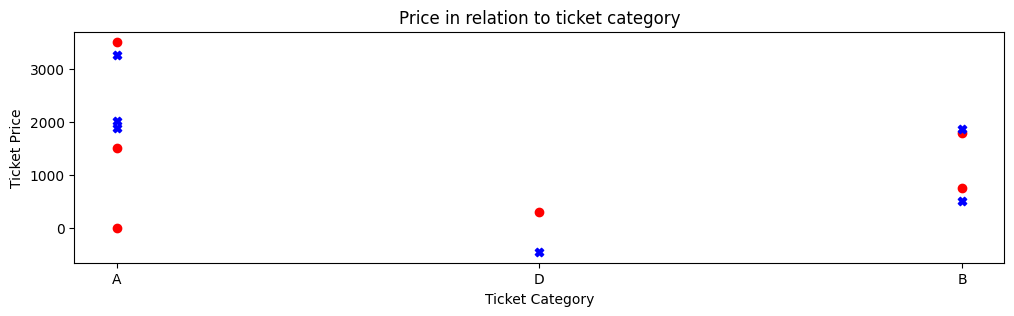

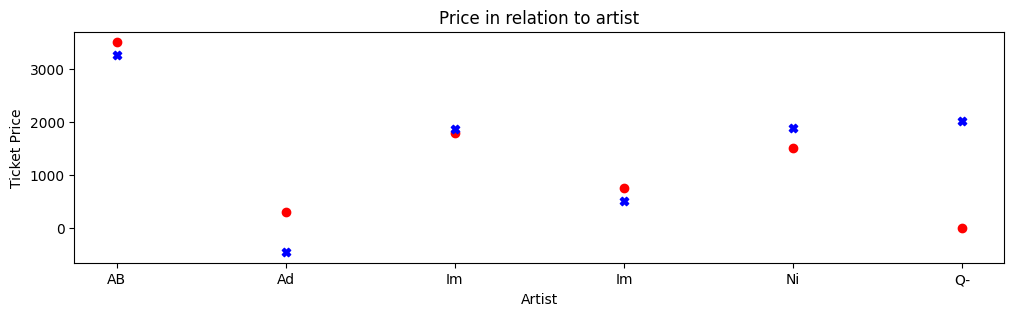

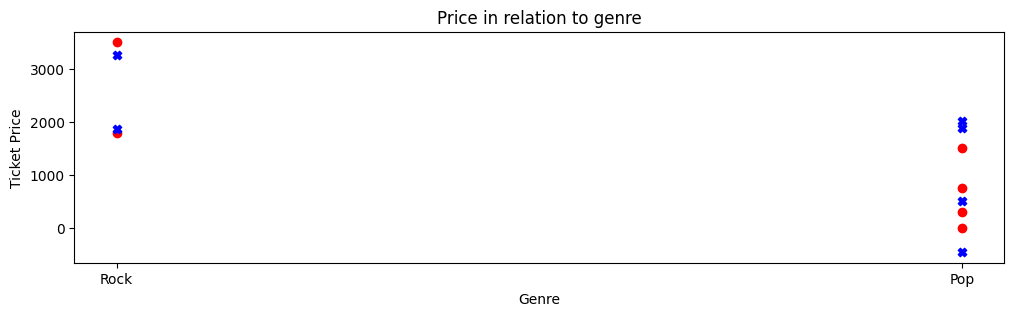

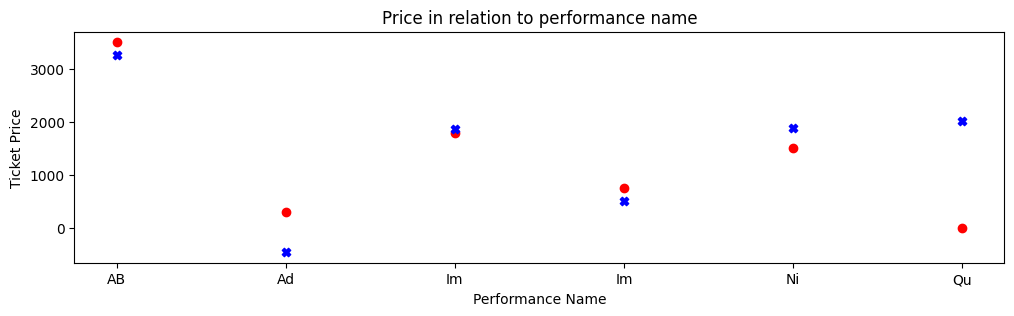

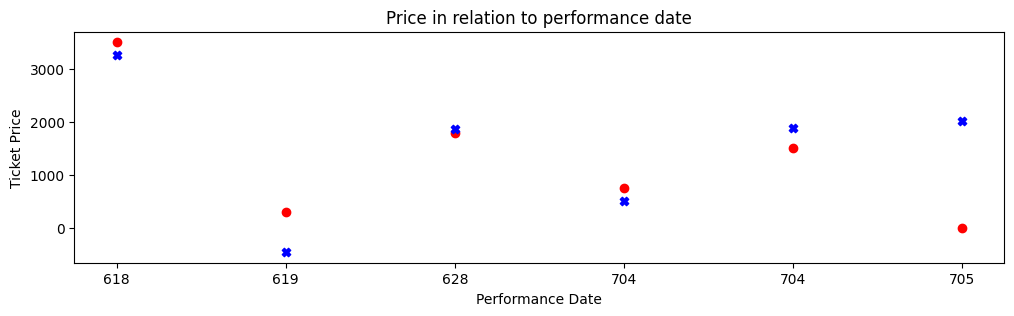

In [102]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lin = linear_model.predict(X_test)
X_test_decoded = X.iloc[24:30]
visualise_data(X_test_decoded, y_test, y_pred=y_pred_lin)

In [103]:
y_train_pred_lin = linear_model.predict(X_train)
for i in range(10):
    print(f'Actual price: {y_train[i]}. Predicted price: {y_train_pred_lin[i]}')

Actual price: 2000. Predicted price: 2015.6105100463676
Actual price: 900. Predicted price: 958.0285076421094
Actual price: 200. Predicted price: 199.99999999999977
Actual price: 1000. Predicted price: 1000.0000000000007
Actual price: 900. Predicted price: 899.9999999999993
Actual price: 450. Predicted price: 190.12536493216544
Actual price: 2000. Predicted price: 2023.415765069551
Actual price: 3000. Predicted price: 2818.512794092392
Actual price: 950. Predicted price: 950.0000000000018
Actual price: 900. Predicted price: 912.9572385368383


### Evaluating the model using MSE and $R^{2}$

In [104]:
mse = mean_squared_error(y_test, y_pred_lin)  # Mean Squared Error
r2 = r2_score(y_test, y_pred_lin)  # R-squared score

print(f"Mean Squared Error: {mse}")
print(f"R-squared score: {r2}")

Mean Squared Error: 817008.813148724
R-squared score: 0.3964537572799659


### Trying polynomial regression with degree 2

In [105]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

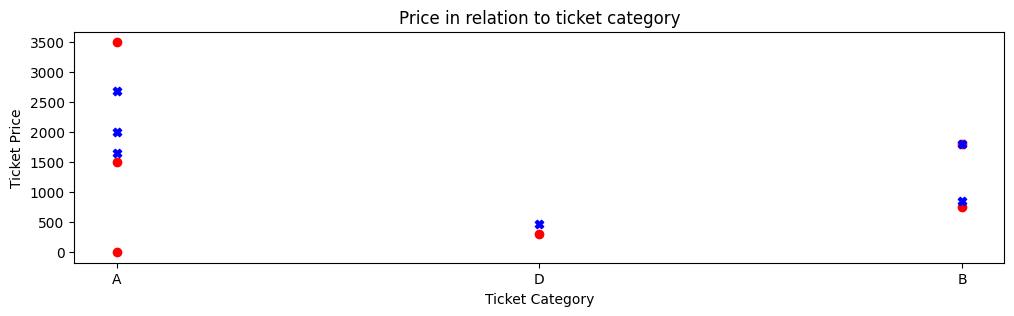

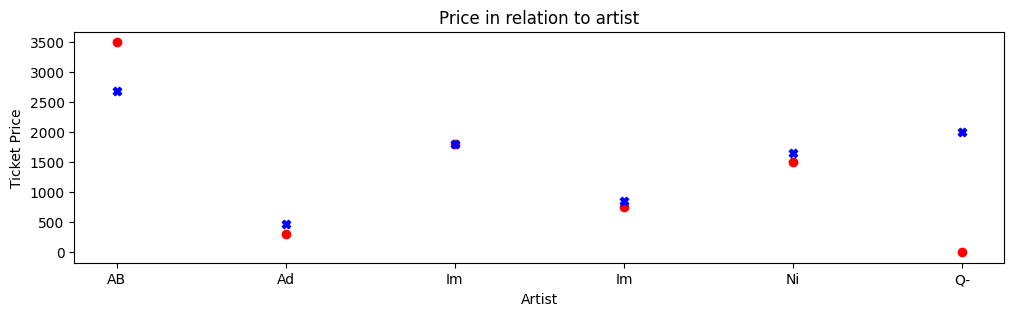

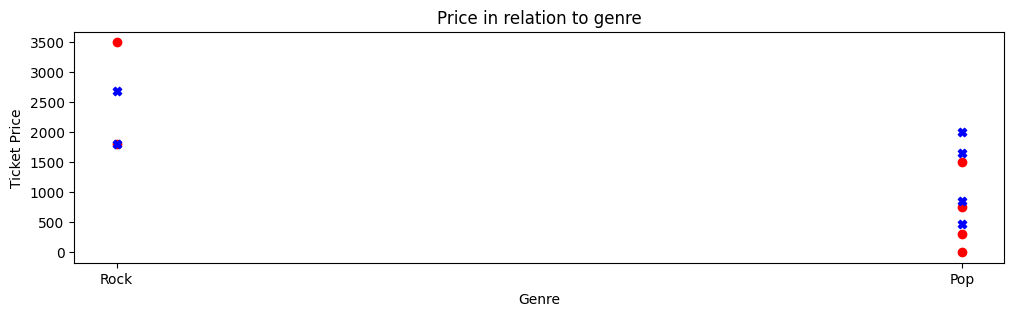

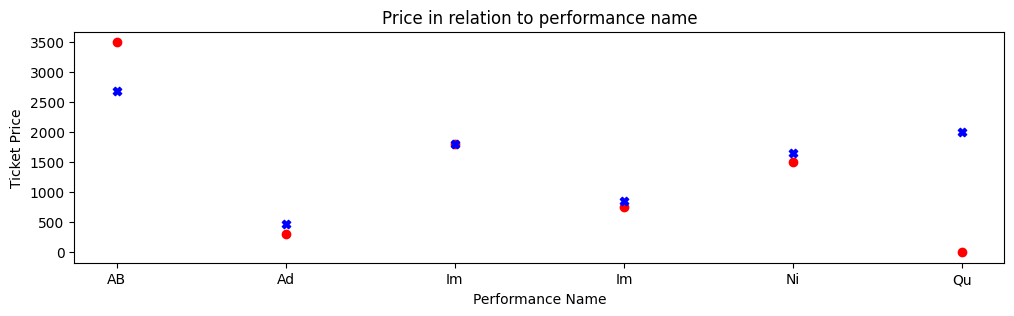

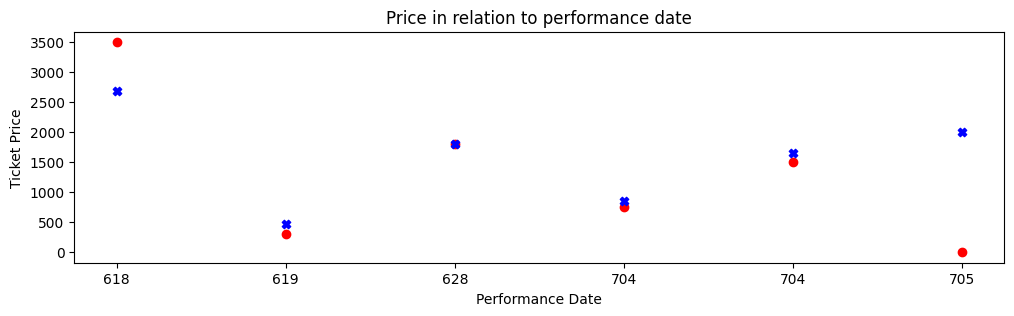

In [106]:
polynomial_model = LinearRegression()
polynomial_model.fit(X_train_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred_poly = polynomial_model.predict(X_test_poly)
visualise_data(X_test_decoded, y_test, y_pred=y_pred_poly)

In [107]:
y_train_pred_poly = polynomial_model.predict(X_train_poly)
for i in range(10):
    print(f'Actual price: {y_train[i]}. Predicted price: {y_train_pred_poly[i]}')

Actual price: 2000. Predicted price: 2000.0000000000007
Actual price: 900. Predicted price: 899.9999999999982
Actual price: 200. Predicted price: 200.0000000000009
Actual price: 1000. Predicted price: 1000.0
Actual price: 900. Predicted price: 900.0000000000032
Actual price: 450. Predicted price: 449.99999999999955
Actual price: 2000. Predicted price: 2000.0
Actual price: 3000. Predicted price: 2999.999999999998
Actual price: 950. Predicted price: 950.0000000000018
Actual price: 900. Predicted price: 900.0000000000014


In [108]:
mse = mean_squared_error(y_test, y_pred_poly)  # Mean Squared Error
r2 = r2_score(y_test, y_pred_poly)  # R-squared score

print(f"Mean Squared Error: {mse}")
print(f"R-squared score: {r2}")

Mean Squared Error: 788839.1131848508
R-squared score: 0.41726346740564046
